In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras import Input,models,layers,optimizers,metrics
from keras.layers import  Dense,Flatten,Activation,Dropout
from keras.applications import VGG16
from keras.callbacks import EarlyStopping

import  numpy as np
import matplotlib.pyplot as plt

In [2]:
#학습셋의 변형을 설정하는 부분입니다.
train_datagen = ImageDataGenerator(rescale=1./255,#주어진 이미지 크기를 설정
                                   horizontal_flip=True,#수평 대칭 이미지를 50%확률로 만들어 추가
                                   width_shift_range=0.1#전체크기의 15%범위에서 좌우로 이동
                                   ,height_shift_range=0.1)
#마찬가지로 위아래로 이동
train_generator = train_datagen.flow_from_directory(
    './data-ch20/train',
    target_size=(150,150),
    batch_size=5,
    class_mode='binary'
)

Found 160 images belonging to 2 classes.


In [4]:
#테스트셋의 정규화를 설정
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    './data-ch20/train',
    target_size=(150, 150),
    batch_size=5,
    class_mode='binary'
)



Found 160 images belonging to 2 classes.


In [5]:
#VGG16 모델을 불러옵니다.
transfer_model = VGG16(weights='imagenet',include_top=False,
                       input_shape=(150,150,3))
transfer_model.trainable = False

58889256/58889256 [==============================] - 6s 0us/step


In [7]:
#우리의 모델을 설정합니다.
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 activation_1 (Activation)   (None, 1)                

In [8]:
#모델의 실행 옵션을 설정
finetune_model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(learning_rate=0.0002),metrics=['accuracy'])

In [9]:
#학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=5)

In [10]:
#모델을 실행합니다.
history = finetune_model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    validation_steps=10,
    callbacks=[early_stopping_callback]
)

Epoch 1/20
32/32 [==============================] - 4s 19ms/step - loss: 0.6887 - accuracy: 0.6187 - val_loss: 0.5433 - val_accuracy: 0.7400
Epoch 2/20
32/32 [==============================] - 0s 14ms/step - loss: 0.5247 - accuracy: 0.7375 - val_loss: 0.4294 - val_accuracy: 0.8600
Epoch 3/20
32/32 [==============================] - 0s 14ms/step - loss: 0.4334 - accuracy: 0.8188 - val_loss: 0.2660 - val_accuracy: 0.9400
Epoch 4/20
32/32 [==============================] - 0s 14ms/step - loss: 0.3744 - accuracy: 0.8562 - val_loss: 0.2803 - val_accuracy: 0.9200
Epoch 5/20
32/32 [==============================] - 0s 14ms/step - loss: 0.3089 - accuracy: 0.8813 - val_loss: 0.2030 - val_accuracy: 0.9600
Epoch 6/20
32/32 [==============================] - 0s 14ms/step - loss: 0.2607 - accuracy: 0.9125 - val_loss: 0.2010 - val_accuracy: 0.9600
Epoch 7/20
32/32 [==============================] - 0s 15ms/step - loss: 0.2719 - accuracy: 0.8938 - val_loss: 0.1850 - val_accuracy: 0.9400
Epoch 8/20
32

In [11]:
#검증셋과 학습셋 오차를 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

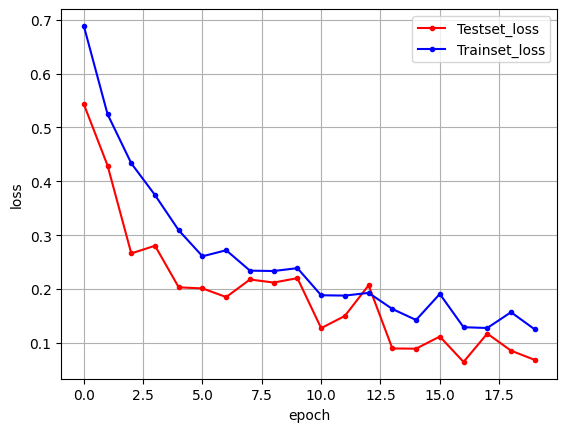

In [12]:
x_len = np.arange(len(y_loss))
plt.plot(x_len,y_vloss,marker='.',c='red',label='Testset_loss')
plt.plot(x_len,y_loss,marker='.',c='blue',label='Trainset_loss')
#그래프에 그리드+레이블
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()